In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets

(x_train, y_train),(x_test, y_test) = datasets.fashion_mnist.load_data()

# Las imágenes tiene un tamaño de 28x28(pixeles de 0 a 255)
# Se escalarán a 32x32 y se normalizarán los pixeles a 0-1
def preprocess(imgs):
  imgs = imgs.astype('float32')/255.0
  imgs = np.pad(imgs,((0,0),(2,2),(2,2)), constant_values=0.0)
  imgs = np.expand_dims(imgs,-1)
  return imgs

x_train = preprocess(x_train)
x_test =  preprocess(x_test)

4422102/4422102 [==============================] - 0s 0us/step


In [2]:
# ENCODER
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

encoder_input=layers.Input(
    shape=(32,32,1),name="encoder_input")

x=layers.Conv2D(32,(3,3),strides=2,activation='relu',padding='same')(encoder_input)
x=layers.Conv2D(64,(3,3),strides=2,activation='relu',padding='same')(x)
x=layers.Conv2D(128,(3,3),strides=2,activation='relu',padding='same')(x)
shape_before_flattening=K.int_shape(x)[1:]

x=layers.Flatten()(x)
encoder_output=layers.Dense(2,name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

In [4]:
# DECODER
# El Decoder es un espejo del encoder, se usan convolutional transpose layers
decoder_input = layers.Input(shape=(2,), name="decoder_input")
#Conectar la entrada a una capa Densa
x=layers.Dense(np.prod(shape_before_flattening))(decoder_input)
# Reajustar el vector en un tensor que se pueda alimentar como entrada
# en la primera capa Transpose
x=layers.Reshape(shape_before_flattening)(x)
x=layers.Conv2DTranspose(128,(3,3),strides=2,
                         activation='relu',padding="same")(x)
x=layers.Conv2DTranspose(64,(3,3),strides=2,
                         activation='relu',padding="same")(x)
x=layers.Conv2DTranspose(32,(3,3),strides=2,
                         activation='relu',padding="same")(x)

decoder_output=layers.Conv2D(1,
                             (3,3),
                             strides=1,
                             activation="sigmoid",
                             padding="same",
                             name="decoder_output")(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       1846

In [5]:
# Juntar el Encoder y el Decoder
# Keras permite hacerlo de esta forma. Especificar que la salida del
# autoencoder es la salida del encoder después de pasar por el Decoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

In [6]:
# Compilar el autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# La optimización RMSE (root mean square error) quiere decir que tu salida generada
# será simétricamente distribuida al rededor de los valores de los pixeles cercanos
# Binary cross-entropy es asimétrica. Penaliza erores del extremo con más fuerza
# que los errores cercaos al centro.

# Binary cross-entropy tiende a generar imágenes más borrosas que RMSE
# Pero RMSE tiende a generar imágenes obviamente, con bordes pixeleados

In [7]:
autoencoder.fit(x_train,x_train,epochs=5,batch_size=100,
                shuffle=True,validation_data=(x_test,x_test))

Epoch 1/5
600/600 [==============================] - 20s 11ms/step - loss: 0.2924 - val_loss: 0.2605
Epoch 2/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2574 - val_loss: 0.2566
Epoch 3/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2544 - val_loss: 0.2550
Epoch 4/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2525 - val_loss: 0.2536
Epoch 5/5
600/600 [==============================] - 6s 10ms/step - loss: 0.2508 - val_loss: 0.2517


In [8]:
# Lo primero que se debe hacer es revisar que el autoencoder es capaz
# de recontruir bien las imágenes de entrada

n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

predictions=autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

157/157 [==============================] - 1s 3ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[9.03232722e-05],
         [1.98288653e-05],
         [9.24095802e-05],
         ...,
         [1.66716995e-06],
         [1.19957156e-06],
         [1.22193582e-04]],

        [[3.35458594e-06],
         [4.25906990e-07],
         [3.69572058e-06],
         ...,
         [1.92922570e-07],
         [6.16800619e-08],
         [1.07247624e-05]],

        [[4.57204851e-06],
         [2.23721236e-06],
         [2.53792459e-05],
         ...,
         [4.25906073e-05],
         [6.85996019e-06],
         [1.09793931e-04]],

        ...,

        [[2.12742506e-07],
         [2.62317101e-08],
         [1.11639235e-06],
         ...,
         [7.09085271e-07],
         [1.00318097e-07],
         [5.42566431e-06]],

        [[2.73282467e-06],
         [4.97085409e-07],
         [3.56111286e-06],
         ...,
         [1.11706208e-06],
         [1.84947453e-07],
         [8.08728601e-06]],

        [[2.36698892e-04],
         [5.35468062e-05],
         [1.43087309e-04],
         ...,
 

157/157 [==============================] - 0s 2ms/step


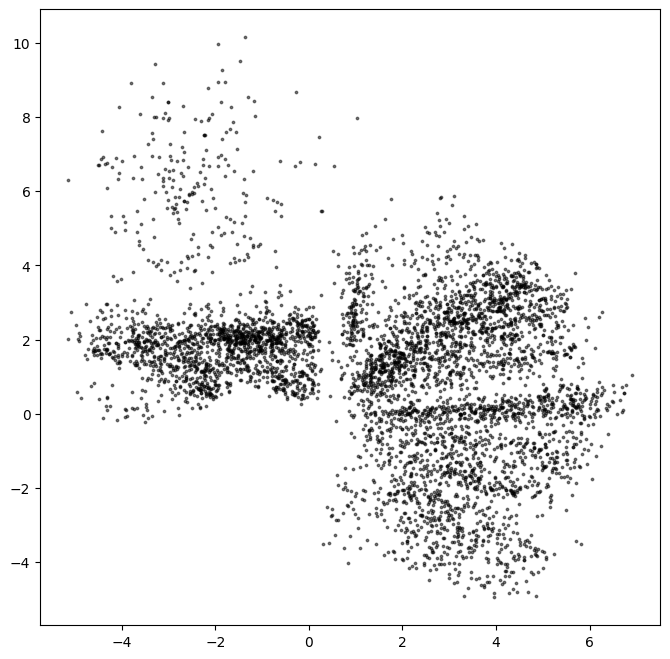

In [16]:
# Visualizando el Latent Space
# Podemos visualizar cómo las imágenes son incrustadas en el espacio latente
# pasando el test set a través del encoder y graficando los resultados incrustados

import matplotlib.pyplot as plt

embeddings = encoder.predict(example_images)
plt.figure(figsize=(8,8))
plt.scatter(embeddings[:,0], embeddings[:,1], c="black", alpha=0.5,s=3)
plt.show()

# Cada punto representa una imagen que ha sido incrustada en el espacio latente
# Each black point represent an image that has been embedded into the latent space.


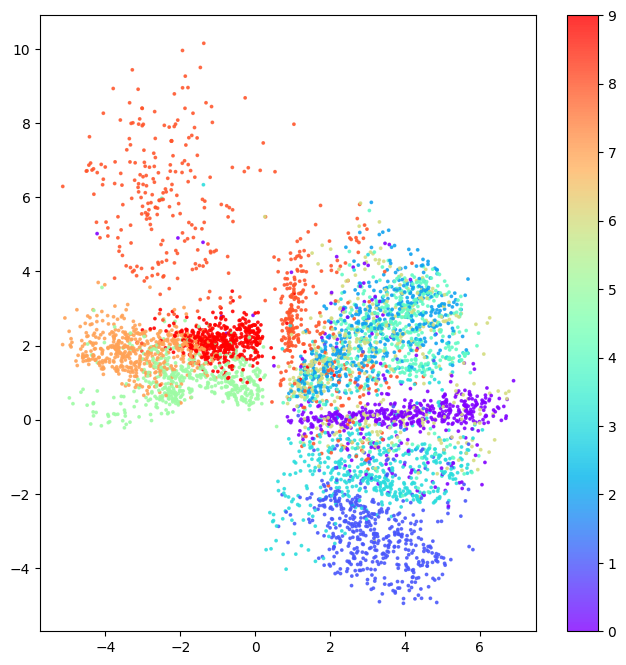

In [17]:
# Colorear el embedding por su Label
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:,0],
            embeddings[:,1],
            cmap="rainbow",
            c=example_labels,
            alpha=0.8,
            s=3)
plt.colorbar()
plt.show()

# Ahora la estructura del espacio latente se vuelve más clara!
# Incluso sin que las etiquetas haya sido nunca mostradas al modelo, el autoencoder
# naturalmente ha agrupado los items que lucen parecidos. Por ejemplo, los puntos
# en azul obscuro de la esquina inferior derecha son todas immágenes diferentes
# de Trousers y los puntos rojos del centro son ankle boots.

In [18]:
# GENERAR NUEVAS IMÁGENES
# Podemos generar nuevas imágenes usando de ejemplo algunos puntos del espacio
# latente y utilizando el decoder para convertir este fondo en un especio de pixel

# Obtener el rango de los embeddings existentes
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
# Muestrear algunos puntos en el espacio latente
sample = np.random.uniform(mins, maxs, size=(18,2))
# Decodificar los puntos Muestreados
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 440ms/step


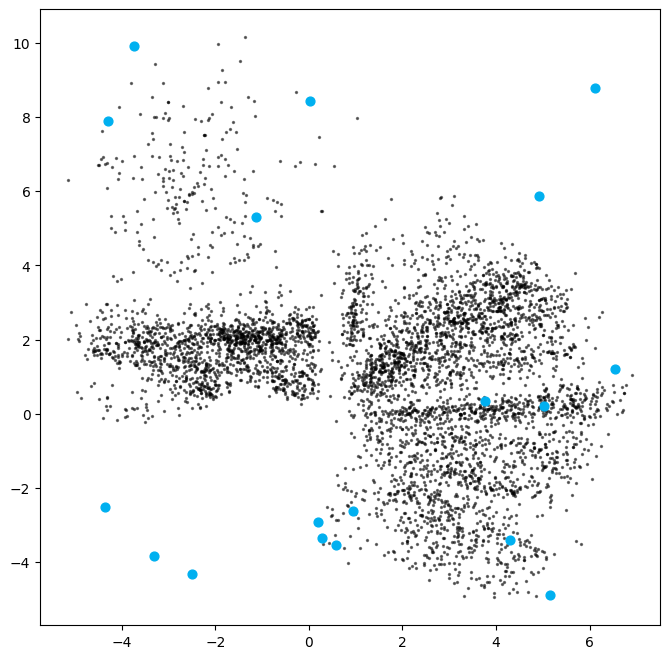

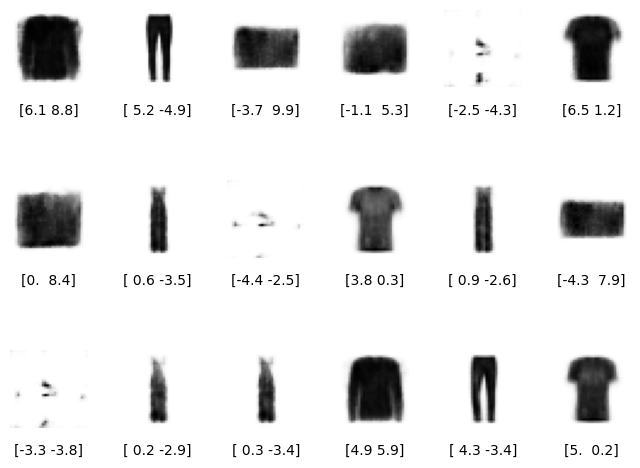

In [21]:
grid_width,grid_height=(6,3)

# Dibujar una gráfica de...
figsize=8
plt.figure(figsize=(figsize,figsize))

# ... los embeddings originales
plt.scatter(embeddings[:,0],embeddings[:,1],c="black",alpha=0.5,s=2)
# ... y la nuevos puntos generados en el espacio latente
plt.scatter(sample[:,0], sample[:,1],c="#00B0F0", alpha=1,s=40)
plt.show

# Y agregar debajo una cuadrícula de los imágenes decodificadas
fig = plt.figure(figsize=(figsize,grid_height*2))
fig.subplots_adjust(hspace=0.4,wspace=0.4)

for i in range(grid_width*grid_height):
  ax=fig.add_subplot(grid_height,grid_width,i+1)
  ax.axis("off")
  ax.text(
      0.5,
      -0.35,
      str(np.round(sample[i,:],1)),
      fontsize=10,
      ha="center",
      transform=ax.transAxes,
  )
  ax.imshow(reconstructions[i,:,:],cmap="Greys")

# Cada punto azul representa una imagen, con el vector incrustado.
# Algunos items son representados por un área más pequeña que otros items
# La distribución no es simétrica sobre el punto(0,0). Por ejemplo, hay puntos
# más en y-positivo que en y-negativo.
# Hay espacios más grandes entre los colores que contiene pocos puntos


8/8 [==============================] - 0s 19ms/step


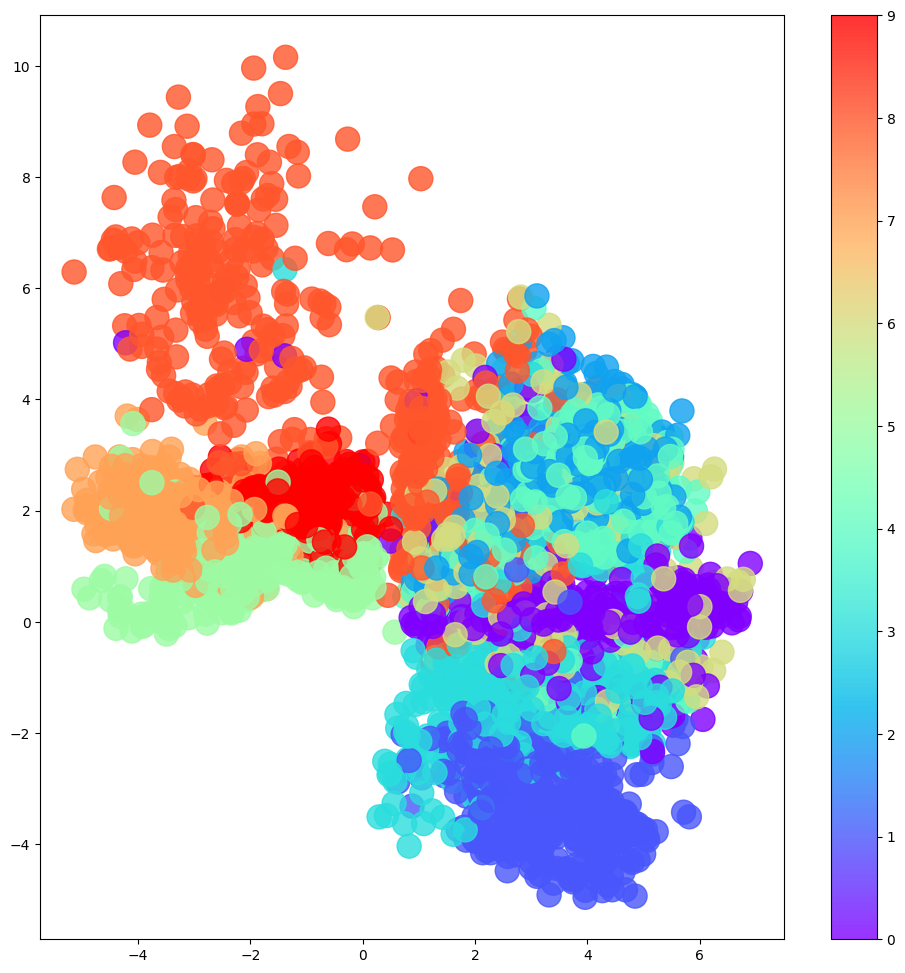

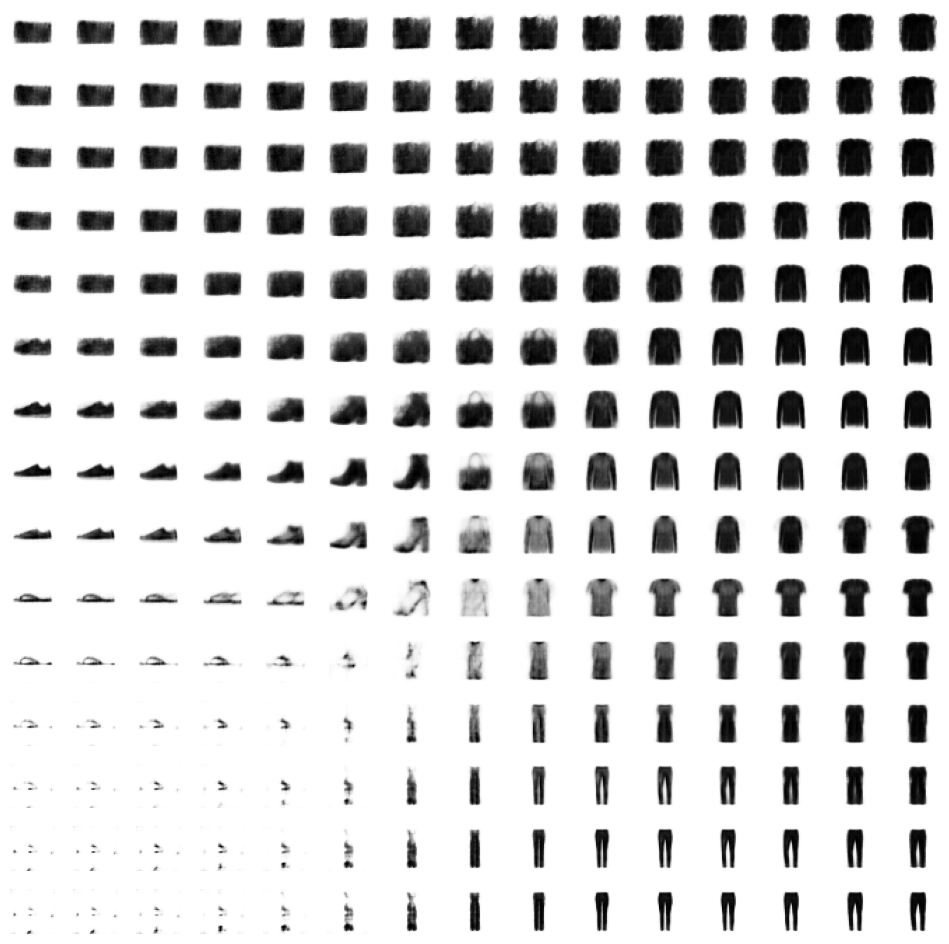

In [22]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")